# Lithology Prediction with Extreme Gradient Boosting

Author: Promise Ekeh

Date: 25/08/2021

This project was for my Msc project at Imperial College London

In [2]:
#%matplotlib notebook
import time
import pandas as pd
import numpy as np
import numpy.random as nr
import random
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean
from collections import Counter

from sklearn import preprocessing

import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight
import operator
from scipy.signal import savgol_filter
import pywt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from scipy.stats.mstats import winsorize

In [3]:
sklearn.__version__

'0.23.2'

In [203]:
!python --version

Python 3.8.3


## FUNCTIONS DEFINITIONS

In [179]:
#Functions for evaluation
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

def evaluate_preds(y_true, y_preds):
    """
    Performs model evaluation  on y_true labels vs. y_pred labels and cross validation on model, X and y
    on a classification.
    """
    
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average= 'weighted')
    recall = recall_score(y_true, y_preds, average= 'weighted')
    f1 = f1_score(y_true, y_preds, average= 'weighted')
    penalty_score= score(y_true.values, y_preds)
    Class = classification_report(y_true.values, y_preds)
    

    metric_dict = {"accuracy": np.round(accuracy, 2),
                   "precision": np.round(precision, 2),
                   "recall": np.round(recall, 2),
                   "f1": np.round(f1, 2),
                   "penalty_score": np.round(penalty_score, 2)}
    
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    print(f"Penalty_score: {penalty_score}")
    #print(f"Class_Report: {Class}")
    
    

def plot_conf_mat(y_true, y_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().

    Takes True label and predicted label
    """
    
    conf_mat = confusion_matrix(y_true, y_pred)
    cmn = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cmn, fmt='.2%',
                     annot=True, # Annotate the boxes with conf_mat info
                     cbar='Blues')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    
    # Fix the broken annotations (this happened in Matplotlib 3.1.1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top-0.5);

In [5]:
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

def feat_aug(data, well, depth):
    
    # Augment features
    data_aug = np.zeros((data.shape[0], data.shape[1]*2))
    for w in np.unique(well.astype(str)):
        data_aug_grad = augment_features_gradient(data, depth)
        data_aug = np.concatenate((data, data_aug_grad), axis=1)
    
    return data_aug

In [6]:
#from jampier C
def feature_engineering(df):

        # Calculate gamma ray index (IGR)
        list_igr = ''
        for well in df['WELL'].unique():
            df_aux = df[df['WELL'] == well]
            GR_max = df_aux['GR_win'].max()
            GR_min = df_aux['GR_win'].min()
            df_aux['IGR'] = df_aux['GR_win'].apply(lambda x: (x-GR_min)/(GR_max-GR_min))
            if list_igr == '':
                list_igr = df_aux['IGR'].values
            else:
                list_igr = np.concatenate([list_igr,df_aux['IGR'].values])

        df['IGR'] = list_igr 
        return df
    

    
def vclay(df):
#     df['VCLAY'] = (df['GR'] - df['GR'].min()) /(df['GR'].max()-df['GR'].min())
#     df['VCLAY_SP'] = (df['SP'] - -(10)) /(-40 - -(10))
    

        # Calculate gamma ray index (IGR)
#     df['VCLAY'] = (df['GR_win'] - df['GR_win'].min()) /(df['GR_win'].max()-df['GR_win'].min())
   df['VCLAY'] = (df['GR_win'] - 30) /(170-30)
    #df['VCLAY_SP'] = (df['SP_win'] - -(10)) /(-40 - -(10))
#     return df


def bad_hole(df): 
    df['X'] = (df['BS'] - df['CALI'])/ df['BS']
    
    index_bh= df[df['X'] > 0.20].index
    df.drop(index_bh, inplace=True)
    df.drop(['X', 'BS'], axis=1, inplace=True)
    return df


def use_logs(data, logs):

    data = data[logs]
    

    
    data['GR_win'] = winsorize(data['GR'], limits=(0, 0.005))
    data['SP_win'] = winsorize(data['SP'], limits=(0.02, 0.35))
    #data['PEF_win'] = winsorize(data['PEF'], limits=(0, 0.45))
    data['DRHO_win'] = winsorize(data['DRHO'], limits=(0.05, 0.4))
#    data['NPHI_win'] = winsorize(data['NPHI'], limits=(0, 0.36))
#     data['RMED_win'] = winsorize(data['RMED'], limits=(0, 0.05))
#     data['RDEP_win'] = winsorize(data['RDEP'], limits=(0, 0.05))
    
    data.drop(['GR', 'SP', 'DRHO'], axis=1, inplace=True)
#     data.fillna(-999, inplace=True)

        
    return data

    

In [181]:
def preprocess(data):
    
    log= ['DEPTH_MD', 'Z_LOC', 'WELL', 'PEF', 'CALI', 'RHOB', 'GR', 'NPHI', 'DTC', 'SP', 'DRHO', 'RDEP','RMED']  
#     log= ['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC',
#        'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF',
#        'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
#        'ROPA', 'RXO' ]  
    
    
    df = data[log]

    #Applying Winsorization
    df['GR_win'] = winsorize(df['GR'], limits=(0, 0.005))
    data['SP_win'] = winsorize(df['SP'], limits=(0.02, 0.35))
    #data['PEF_win'] = winsorize(data['PEF'], limits=(0, 0.45))
    df['DRHO_win'] = winsorize(df['DRHO'], limits=(0.05, 0.4))
#    data['NPHI_win'] = winsorize(data['NPHI'], limits=(0, 0.36))
#     data['RMED_win'] = winsorize(data['RMED'], limits=(0, 0.05))
#     data['RDEP_win'] = winsorize(data['RDEP'], limits=(0, 0.05))
    
    df.drop(['GR', 'SP', 'DRHO'], axis=1, inplace=True)
    

    # dealing with bad hole
#     df['X'] = (df['CALI'] - df['BS'])/ df['CALI']
#     df['X']= df['X']**2
#     df['X']= df['X']**0.5
    
#     index_bh= df[df['X'] > 0.25].index
#     df.drop(index_bh, inplace=True)
#     df.drop(['X', 'BS'], axis=1, inplace=True)


    # encodoing Group and formation names
#     df['GROUP_encoded'] = df['GROUP'].astype('category')
#     df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
#     df['FORMATION_encoded'] = df['FORMATION'].astype('category')
#     df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
#     df['WELL_encoded'] = df['WELL'].astype('category')
#     df['WELL_encoded'] = df['WELL_encoded'].cat.codes
#     print(f'shape of dataframe after label encoding columns {df.shape}')


#     df = df.drop([ 'GROUP', 'FORMATION'], axis=1)
    
    X= feature_engineering(df)
    X = vclay(df)
    X= pd.DataFrame(df)
    

    
    y = data['FORCE_2020_LITHOFACIES_LITHOLOGY']
    #y= y.dropna(inplace=True)
    lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
    y = y.map(lithology_numbers)
    
#     y.drop(index_bh, inplace=True)
    
    well = df.WELL.values
    depth = df.DEPTH_MD.values
    X= X.drop(['WELL'], axis=1)


#     order = 3;
#     framelen = 9;
#     #X_tf=X.copy()
#     #sgf = sgolayfilt(x,order,framelen);
#     #X = savgol_filter (X, framelen, order)
#     X['SP_win'] = savgol_filter (X['SP_win'], framelen, order)
#     X['GR_win'] = savgol_filter (X['GR_win'], framelen, order)
# #     X['PEF_win'] = savgol_filter (X[ 'PEF_win'], framelen, order, mode='nearest')
#     X['DRHO_win'] = savgol_filter (X[ 'DRHO_win'], framelen, order)
    
    
#     imputer = SimpleImputer(estimator=BayesianRidge(), n_nearest_features=None,
#                            imputation_order='ascending')
#                            #, sample_posterior=True)
    #Fit imputer and transform   
#     imputer = IterativeImputer(XGBRegressor(n_estimators=100, tree_method='gpu_hist'))
#     imputer.fit(X)
#     X = imputer.transform(X)
#     X = pd.DataFrame(X)

    
    
    #np.set_printoptions(precision=2)  # For compact display.


    #X= pd.DataFrame(df)
    
    print('---------------Augment--------------')
    
    X, padded_rows = augment_features(X.values, well, depth)
    
#     X= pd.DataFrame(X)
    

    print('---------------Preprocessing Done--------------')
    return X, y
    
        
def resample (X, y):
    '''
    Resampling using RandomUnderSampler to undersample majoirty class(shale)
    and SMOTEENN to oversample minority class
    
    '''
    #X, y = preprocess(data)
    
    
    ### Resampling Methods
    strat = sorted(Counter(y).items())
    strat= dict(strat)
    c= strat[2]*0.5
    c=int(c)
    strat[2] = c
    a= strat[0]*1.16 #or 1.18
    b= strat[1]*1.13
    d= strat[3]*4.5
    e= strat[4]*71
    f= strat[5]*2.6
    g= strat[6]*16.17
    h= strat[7]*14.6
    i= strat[8]*184.33
    j= strat[9]*7.87
    k= strat[10]*31.4
    l= strat[11]*9.7
    
    a=int(a)
    b=int(b)
    d=int(d)
    e=int(e)
    f=int(f)
    g=int(g)
    h=int(h)
    i=int(i)
    j=int(j)
    k=int(k)
    l=int(l)
    

    under = RandomUnderSampler(sampling_strategy=strat, random_state=30)

    X_un, y_un = under.fit_resample(X, y) 
    strategy = {0:a, 1:b, 2:c, 3:d, 4:e, 5:f,
                6:g, 7:h, 8:i, 9:j, 10:k, 11:l}
        
    strategy = {0:200000, 1:170000, 2:c, 3:150000, 4:120000, 5:150000,
                6:170000, 7:120000, 8:200000, 9:120000, 10:120000, 11:1000}

    ros = RandomOverSampler(sampling_strategy=strategy, random_state=100 )
    X, y = ros.fit_resample(X_un, y_un)

    
    print('---------------Resampling Done--------------')
    return X, y
    
     

    
def fit(X, y):
    '''
    method to train model and make predictions
    returns the test predictions, trained model, and lithology numbers used for making the submission file
    '''
    #X, y= resample(data)
    y= np.array(y)
    print('---------------Started Fitting--------------')
    #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
    #as this improved the validation performance better
    split = 2
    kfold = StratifiedKFold(n_splits=split, random_state=1, shuffle=True)
    
   

    #100 n-estimators and 10 max-depth
    model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree', min_child_weight=20, 
                            objective='multi:softprob', learning_rate=0.1, random_state=30, use_label_encoder=False,
                            subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist', reg_alpha=10,
                            eval_metric='mlogloss', reg_lambda=1500)
    i = 1
    for train_ix, test_ix in kfold.split(pd.DataFrame(X), pd.DataFrame(y)):
    # select rows
        train_X, test_X = pd.DataFrame(X).iloc[train_ix], pd.DataFrame(X).iloc[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        model.fit(train_X, train_y, early_stopping_rounds=100, eval_set=[(test_X, test_y)], verbose=100)
        prediction = model.predict(test_X)
        y_test= pd.DataFrame(test_y)
        print(evaluate_preds(y_test, prediction))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
    return model, split
    


def predict(test, model):
    X, y = preprocess(test)
    pred = np.zeros((len(X), 12))
    pred += model.predict_proba(pd.DataFrame(X))
                  
    pred= pd.DataFrame(pred/split)
    
    pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
    
    y= pd.Series(y)
    pred= pd.Series(pred)
    evaluate_preds(y, pred)
    plot_conf_mat(y, pred)
    return pred
              
              
def plot_feat_imp(model):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(15,10))
    plt.title('FEATURE IMPORTANCE', fontsize=35)
    plt.ylabel('Feature Importance Score', FONTSIZE=20)
    feat_imp.plot(kind='bar', title='FEATURE IMPORTANCE')
    plt.savefig("./image2/Feature Importance.png")
        

## IMPORTING DATA

In [8]:
data = pd.read_csv("train.csv", sep=';')
A = np.load('penalty_matrix.npy')
hidden_test = pd.read_csv("hidden_test.csv", sep=';')
opy = pd.read_csv("test_target.csv", sep=';')
opx = pd.read_csv("test_features.csv", sep=';')
uk = pd.read_csv("UK_3_well.csv")
uk['DTC']= uk['DT']
uk['FORCE_2020_LITHOFACIES_LITHOLOGY']= uk['LITH']
uk=pd.DataFrame(uk)
open_test= pd.concat([opx, opy], axis=1)


In [89]:
data.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE', 'SP_win'],
      dtype='object')

In [9]:
open_test = open_test.loc[:,~open_test.columns.duplicated()]
open_test['FORCE_2020_LITHOFACIES_CONFIDENCE']= np.zeros((len(open_test)))

In [10]:
all_data = pd.concat([data, open_test])

In [11]:
# fig = plt.figure(figsize=(10,8))
# plt.scatter(data.X_LOC, data.Y_LOC, label='Train', c='g')
# plt.scatter(open_test.X_LOC, open_test.Y_LOC, label='Open Test', c='b')
# plt.scatter(hidden_test.X_LOC, hidden_test.Y_LOC, label='Hidden Test', c='r')

# plt.legend(loc ="lower right", prop={'size': 15})
# plt.title('Data Location', fontsize=24)


# plt.show();

In [12]:
# fig = plt.figure(figsize=(20, 10))
# data['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts().plot(kind='bar', color='g')

In [13]:
#train, valid= split_train_test(all_data)

In [14]:
#sorted(Counter(valid['FORCE_2020_LITHOFACIES_LITHOLOGY']).items())

In [15]:
# df= data.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)

# imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# imputer.fit(df)
# Xtrans = imputer.transform(df)

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [182]:
%%time
start_time = time.time()

X, y = preprocess(data)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: "
      f"{elapsed_time:.3f} seconds")

<ipython-input-181-15bd48bdaf00>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GR_win'] = winsorize(df['GR'], limits=(0, 0.005))
<ipython-input-181-15bd48bdaf00>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRHO_win'] = winsorize(df['DRHO'], limits=(0.05, 0.4))
<ipython-input-6-3efde0d707ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

---------------Augment--------------
---------------Preprocessing Done--------------
Elapsed time to compute: 29.363 seconds
Wall time: 29.4 s


In [183]:
%%time
start_time = time.time()

X, y = resample(X, y)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

---------------Resampling Done--------------
Elapsed time to compute the importances: 1.392 seconds
Wall time: 1.39 s


In [184]:
%%time

start_time = time.time()

model, split= fit(X, y)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute: "
      f"{elapsed_time:.3f} seconds")

---------------Started Fitting--------------
[0]	validation_0-mlogloss:2.24741
[99]	validation_0-mlogloss:0.39731
Acc: 88.09%
Precision: 0.88
Recall: 0.88
F1 score: 0.88
Penalty_score: [-0.31499408]
None
-----------------------FOLD 1---------------------
[0]	validation_0-mlogloss:2.24757
[99]	validation_0-mlogloss:0.39806
Acc: 88.13%
Precision: 0.88
Recall: 0.88
F1 score: 0.88
Penalty_score: [-0.31406306]
None
-----------------------FOLD 2---------------------
Elapsed time to compute: 195.547 seconds
Wall time: 3min 15s


<ipython-input-174-7cc5d562c02a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GR_win'] = winsorize(df['GR'], limits=(0, 0.005))
<ipython-input-174-7cc5d562c02a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRHO_win'] = winsorize(df['DRHO'], limits=(0.05, 0.4))
<ipython-input-6-3efde0d707ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

---------------Augment--------------
---------------Preprocessing Done--------------
Acc: 74.69%
Precision: 0.77
Recall: 0.75
F1 score: 0.75
Penalty_score: -0.6430161686969452
Wall time: 7.25 s


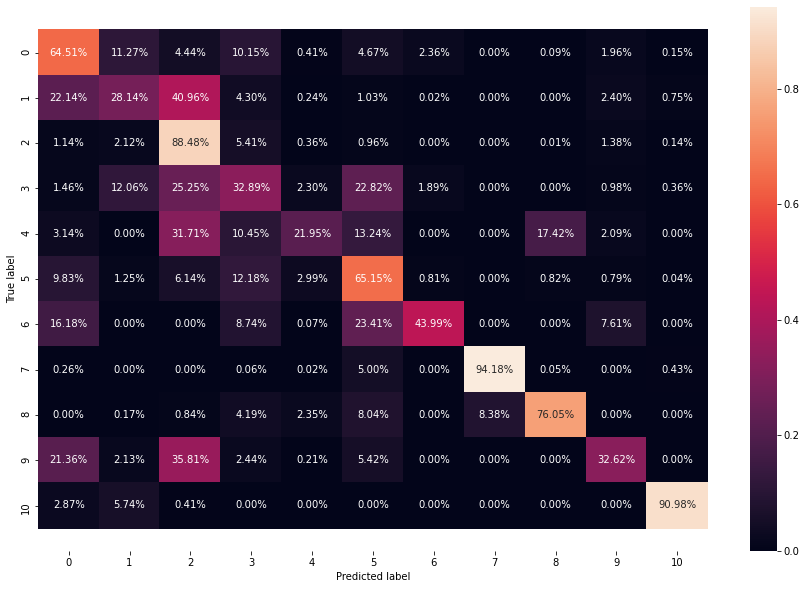

In [180]:
%%time
# with pef shale 5,5
hidden_pred= predict(hidden_test, model)

<ipython-input-181-15bd48bdaf00>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GR_win'] = winsorize(df['GR'], limits=(0, 0.005))
<ipython-input-181-15bd48bdaf00>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRHO_win'] = winsorize(df['DRHO'], limits=(0.05, 0.4))
C:\Users\promi\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

---------------Augment--------------
---------------Preprocessing Done--------------
Acc: 74.28%
Precision: 0.77
Recall: 0.74
F1 score: 0.75
Penalty_score: -0.6524904613675172
Wall time: 5.55 s


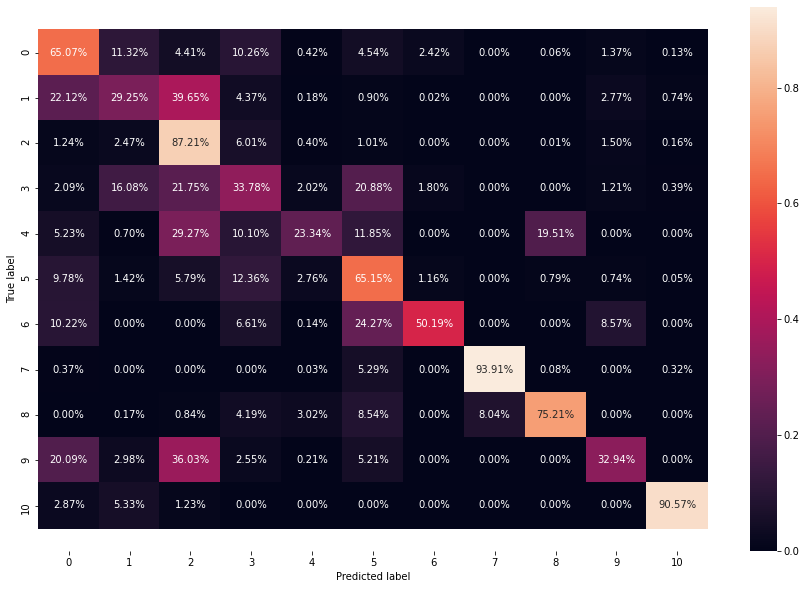

In [185]:
%%time
# with pef shale 0,5
hidden_pred= predict(hidden_test, model)

<ipython-input-138-c75c6ffe2b6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GR_win'] = winsorize(df['GR'], limits=(0, 0.005))
<ipython-input-138-c75c6ffe2b6a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRHO_win'] = winsorize(df['DRHO'], limits=(0.05, 0.4))
C:\Users\promi\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

---------------Augment--------------
---------------Preprocessing Done--------------
Acc: 74.28%
Precision: 0.77
Recall: 0.74
F1 score: 0.75
Penalty_score: -0.6524904613675172
Wall time: 5.29 s


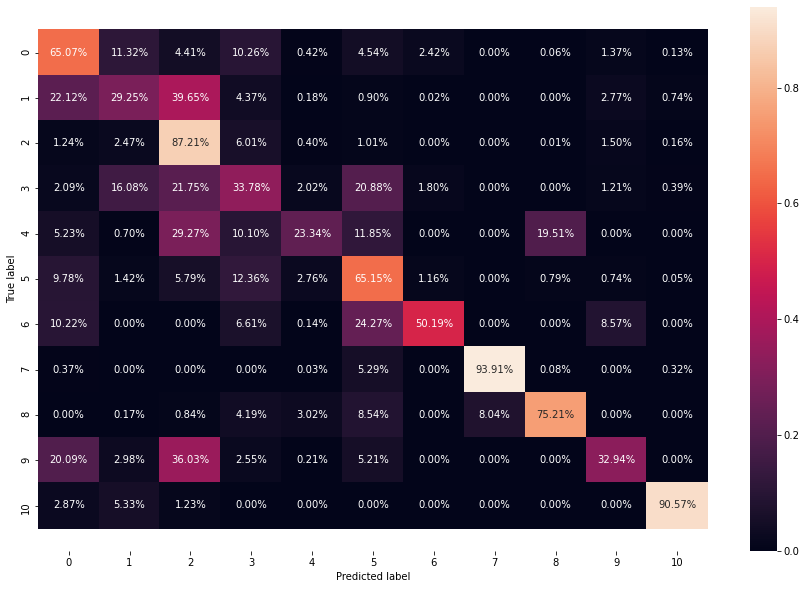

In [142]:
%%time
# with pef shale 0,5
hidden_pred= predict(hidden_test, model)

<ipython-input-76-a85d0609ed99>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GR_win'] = winsorize(df['GR'], limits=(0, 0.005))
<ipython-input-76-a85d0609ed99>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRHO_win'] = winsorize(df['DRHO'], limits=(0.05, 0.4))
C:\Users\promi\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

---------------Augment--------------
---------------Preprocessing Done--------------
Acc: 74.85%
Precision: 0.77
Recall: 0.75
F1 score: 0.75
Penalty_score: -0.6368681421930276
Wall time: 5.7 s


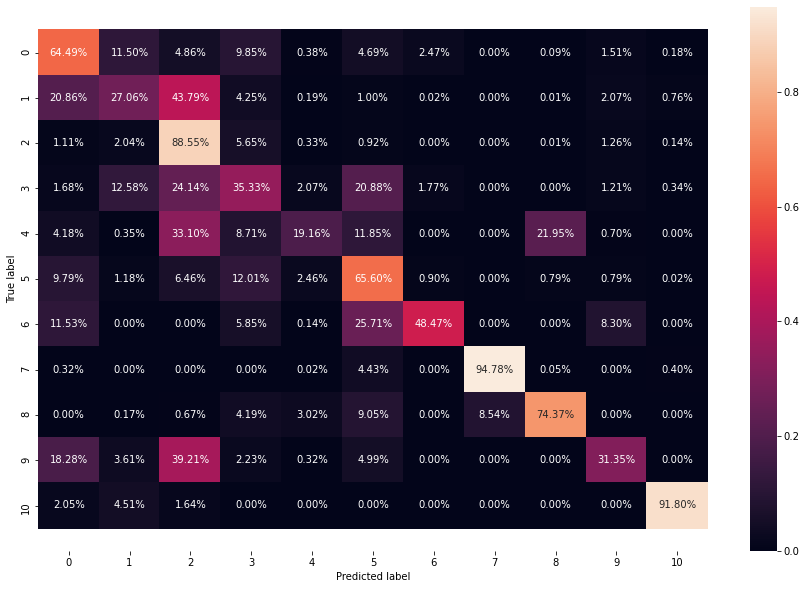

In [81]:

# %%time
# # with pef
# hidden_pred= predict(hidden_test, model)

<ipython-input-70-59c97bcaf36f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GR_win'] = winsorize(df['GR'], limits=(0, 0.005))
<ipython-input-70-59c97bcaf36f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRHO_win'] = winsorize(df['DRHO'], limits=(0.05, 0.4))
C:\Users\promi\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

---------------Augment--------------
---------------Preprocessing Done--------------
Acc: 73.91%
Precision: 0.77
Recall: 0.74
F1 score: 0.75
Penalty_score: -0.6599395818524963
Wall time: 5.27 s


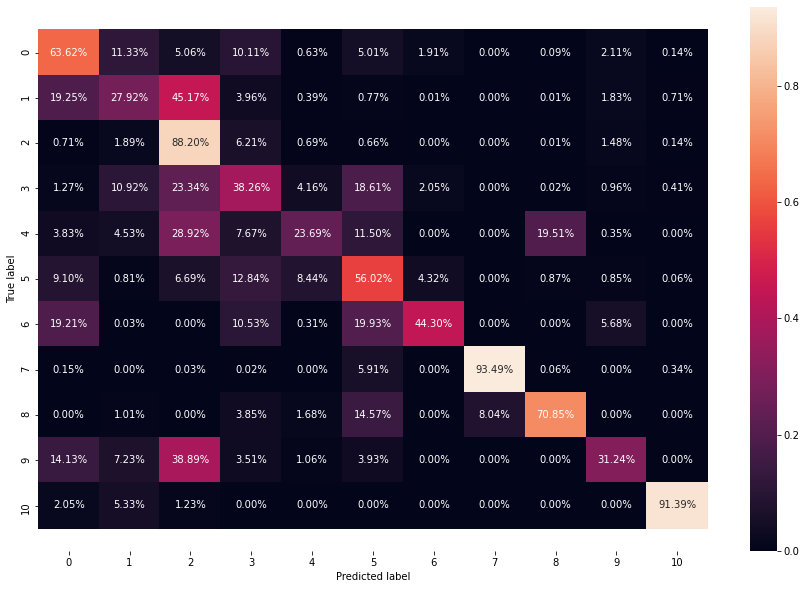

In [74]:
# without pef
# %%time
# hidden_pred= predict(hidden_test, model)

<ipython-input-143-ffc4144e7aca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GR_win'] = winsorize(df['GR'], limits=(0, 0.005))
<ipython-input-143-ffc4144e7aca>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DRHO_win'] = winsorize(df['DRHO'], limits=(0.05, 0.4))
C:\Users\promi\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

---------------Augment--------------
---------------Preprocessing Done--------------


C:\Users\promi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\promi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 72.37%
Precision: 0.75
Recall: 0.72
F1 score: 0.73


<ipython-input-95-93bf926c98dd>:47: RuntimeWarning: invalid value encountered in true_divide
  cmn = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]


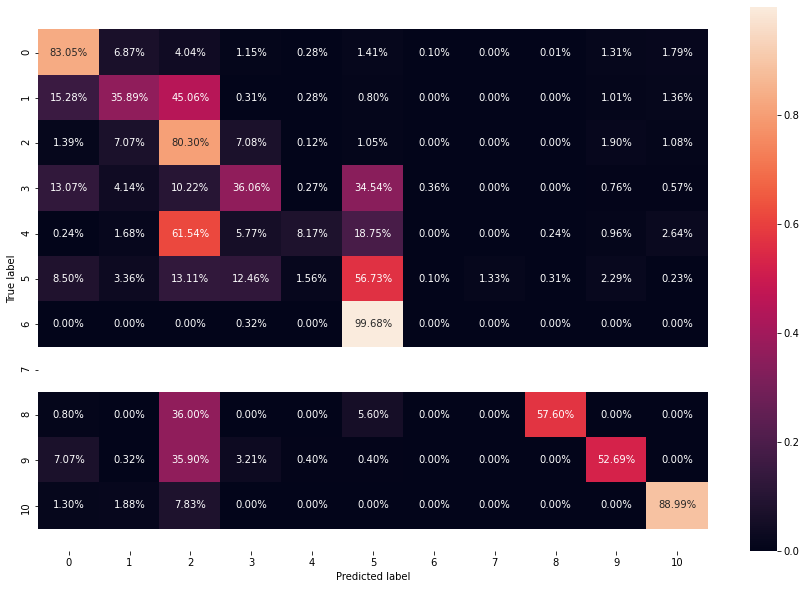

In [168]:
open_pred= predict(open_test, model)

In [ ]:
all_pred, all_metric = predict(all_data, model)

In [87]:
import pickle
pickle.dump(model, open('best_Xgb1withpef.pkl', 'wb'))

#to load model
#pickle.load(open('Xgb1.pkl', 'rb'))

In [ ]:
from joblib import dump, load
# dump(model, filename='modelname.joblib')
# load(model, filename='modelname.joblib')

# Visualization

In [35]:
#Now define a function that creates a plot with log curves, as well as a lithofacies track. 
#This plot will be flexible, in that we can provide a list of curve mnemonics that 
#we want to include in the plot.

#Now define a function that creates a plot with log curves, as well as a lithofacies track. 
#This plot will be flexible, in that we can provide a list of curve mnemonics that 
#we want to include in the plot.

def make_facies_log_plot(logs, curves, well_name, facies_colors):
        
    #make sure logs are sorted by depth
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(logs['litho_real'].values.reshape(-1, 1),50,axis=1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs.Depth,colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((11*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Lithology')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'% well_name, fontsize=14,y=0.94)    
    
    

def compare_facies_plot(logs, well_name, facies_name, facies_colors, vmax):
    
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    #ztop=3300; zbot=zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['litho_real'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs['litho_pred'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(10, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.RDEP, logs.Depth, '-r')
    ax[2].plot(logs.NPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.RHOB, logs.Depth, '-', color='b')
    ax[4].plot(logs.PEF, logs.Depth, '-', color='black')
    
   
    
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=vmax)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=vmax)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((10*' ').join(facies_name))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_ylabel("DEPTH")
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(0,150)
    ax[1].set_xlabel("RDEP")
    ax[1].set_xlim(logs.RDEP.min(),logs.RDEP.max())
    ax[2].set_xlabel("NPHI")
    ax[2].set_xlim(logs.NPHI.min(),logs.NPHI.max())
    ax[3].set_xlabel("RHOB")
    ax[3].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[4].set_xlabel("PEF")
    ax[4].set_xlim(logs.PEF.min(),logs.PEF.max())
    ax[5].set_xlabel('litho_real')
    ax[6].set_xlabel('litho_pred')
    
   
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([]);
    
   
    f.suptitle('Well: %s' % well_name, fontsize=14,y=0.94)    


def use(data, *args):

    columns = []
    for _ in args:
        columns.append(_)
        
    data = data.loc[:, (columns)]
    #data.fillna(data.mean(), inplace=True)
    data.fillna(0, inplace=True)
        
    return data
    
def prep(data):
    #log= ['DEPTH_MD','CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'DRHO']
    log= ['DEPTH_MD','WELL', 'Z_LOC', 'GROUP', 'CALI', 'GR', 'RHOB', 'GR', 'NPHI', 'PEF', 'DRHO', 'RMED', 'RDEP']
#     data['RMED'] = outlier_removal(data['RMED'], operator.le, 0, np.nan)
#     data['GR'] = outlier_removal(data['GR'], operator.gt, 200, 200)
    
    X= use(data, *log)

    #X= precond_train(X)
    
    
    
    y = data['FORCE_2020_LITHOFACIES_LITHOLOGY']
    #y= y.dropna(inplace=True)
    lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
    y = y.map(lithology_numbers)

    return X, y


In [36]:
def group(logs, well_name, facies_name, facies_colors, vmax):
    
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
   
    
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
  
    ax[1].plot(logs.GROUP, logs.Depth, '-', color='y')
   
    
    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_ylabel("DEPTH")
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(0,400)
    ax[1].set_ylabel("DEPTH")

    ax[1].set_xlabel("GROUP")
    #ax[5].set_xlim(0,15)
    
   
    
    ax[1].set_yticklabels([]);
    
   
    f.suptitle('Well: %s' % well_name, fontsize=14,y=0.94)    
    
def evaluate_well(data):
    met = evaluate_preds(data['actual'], data['pred'])
    

In [37]:
test_wells = hidden_test['WELL'].unique()
test_wells

array(['15/9-23', '16/2-7', '16/7-6', '17/4-1', '25/10-9', '31/2-10',
       '31/2-21 S', '34/3-2 S', '35/11-5', '35/9-7'], dtype=object)

In [38]:
wells, target = prep(hidden_test)

wells = pd.concat([wells, target, pd.Series(hidden_pred, index=target.index)], axis=1).rename(columns = {0:'pred'})
wells['actual']=wells['FORCE_2020_LITHOFACIES_LITHOLOGY']
wells

,DEPTH_MD,WELL,Z_LOC,GROUP,CALI,GR,RHOB,GR,NPHI,PEF,DRHO,RMED,RDEP,FORCE_2020_LITHOFACIES_LITHOLOGY,pred,actual
0,1518.2800,15/9-23,-1493.241821,HORDALAND GP.,15.506232,103.451515,0.0,103.451515,0.439925,0.0,0.109706,0.000000,0.878615,2,2,2
1,1518.4320,15/9-23,-1493.393799,HORDALAND GP.,18.524611,94.124893,0.0,94.124893,0.504055,0.0,-0.006418,0.000000,0.874237,2,2,2
2,1518.5840,15/9-23,-1493.545776,HORDALAND GP.,18.855669,93.586487,0.0,93.586487,0.512960,0.0,0.022769,0.000000,0.869858,2,2,2
3,1518.7360,15/9-23,-1493.697754,HORDALAND GP.,19.163353,91.113373,0.0,91.113373,0.500070,0.0,0.024972,0.000000,0.865479,2,2,2
4,1518.8880,15/9-23,-1493.849609,HORDALAND GP.,18.489744,100.228333,0.0,100.228333,0.277670,0.0,0.024527,0.849849,0.863804,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122392,2973.2988,35/9-7,-2943.444580,BAAT GP.,8.276272,90.720284,0.0,90.720284,0.000000,0.0,0.502458,2.820439,3.158570,2,2,2
122393,2973.4508,35/9-7,-2943.595947,BAAT GP.,8.267273,87.062027,0.0,87.062027,0.000000,0.0,0.374753,3.020778,3.332977,2,2,2
122394,2973.6028,35/9-7,-2943.747559,BAAT GP.,8.250099,86.115921,0.0,86.115921,0.000000,0.0,0.211487,2.795711,3.044179,2,2,2
122395,2973.7548,35/9-7,-2943.899170,BAAT GP.,0.000000,89.497131,0.0,89.497131,0.000000,0.0,0.147950,2.658694,2.847681,2,2,2


In [187]:
def evaluate_preds(y_true, y_preds):
    """
    Performs model evaluation  on y_true labels vs. y_pred labels and cross validation on model, X and y
    on a classification.
    """
    
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average= 'weighted')
    recall = recall_score(y_true, y_preds, average= 'weighted')
    f1 = f1_score(y_true, y_preds, average= 'weighted')
    
    Class = classification_report(y_true.values, y_preds)
    
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    #print(f"Class_Report: {Class}")

In [150]:
i =wells[wells['WELL']== '15/9-23']
ii =wells[wells['WELL']== '16/2-7']
iii =wells[wells['WELL']== '16/7-6']
iv =wells[wells['WELL']== '17/4-1']
v =wells[wells['WELL']== '25/10-9']
vi =wells[wells['WELL']== '31/2-10']
vii =wells[wells['WELL']== '31/2-21 S']
viii =wells[wells['WELL']== '34/3-2 S']
ix =wells[wells['WELL']== '35/11-5']
x =wells[wells['WELL']== '35/9-7']

In [196]:
evaluate_well(x)

Acc: 71.57%
Precision: 0.79
Recall: 0.72
F1 score: 0.75


In [48]:
X_hid, y_hid = prep(hidden_test)

In [49]:
well = data['WELL']

lithofacies = {0: 'Sand', 1: 'SS/Shale',
               2: 'Shale', 3: 'Marl', 4: 'Dolo', 5: 'Limes', 6: 'Chalk', 7: 'Halite',
               8: 'Anhy', 9: 'Tuff',10: 'Coal'}

facies_names = lithofacies.values()

facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', 'magenta', '#000000']

facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

In [50]:
group_dict_num= {0: 0,
            'NORDLAND GP.': 1,
             'HORDALAND GP.': 2,
             'ROGALAND GP.': 3, 
             'SHETLAND GP.': 4,
             'CROMER KNOLL GP.': 5, 
             'VIKING GP.': 6, 
             'BOKNFJORD GP.': 7,
             'VESTLAND GP.': 8, 
             'ZECHSTEIN GP.': 9,
             'HEGRE GP.': 10, 
             'ROTLIEGENDES GP.': 11, 
             'TYNE GP.': 12, 
             'DUNLIN GP.': 13, 
             'BAAT GP.': 14}

In [51]:
group_dict= {
            'NORDLAND GP.': 'NOR',
             'HORDALAND GP.': 'HOR',
             'ROGALAND GP.': 'ROG', 
             'SHETLAND GP.': 'SHE',
             'CROMER KNOLL GP.': 'CK', 
             'VIKING GP.': 'VI', 
             'BOKNFJORD GP.': 'BON',
             'VESTLAND GP.': 'VES', 
             'ZECHSTEIN GP.': 'ZC',
             'HEGRE GP.': 'HE', 
             'ROTLIEGENDES GP.': 'ROT', 
             'TYNE GP.': 'TY', 
             'DUNLIN GP.': 'DUN', 
             'BAAT GP.': 'BAT'}

In [52]:
X_hid['GROUP']= X_hid['GROUP'].map(group_dict)
X_hid

,DEPTH_MD,WELL,Z_LOC,GROUP,CALI,GR,RHOB,GR,NPHI,PEF,DRHO,RMED,RDEP
0,1518.2800,15/9-23,-1493.241821,HOR,15.506232,103.451515,0.0,103.451515,0.439925,0.0,0.109706,0.000000,0.878615
1,1518.4320,15/9-23,-1493.393799,HOR,18.524611,94.124893,0.0,94.124893,0.504055,0.0,-0.006418,0.000000,0.874237
2,1518.5840,15/9-23,-1493.545776,HOR,18.855669,93.586487,0.0,93.586487,0.512960,0.0,0.022769,0.000000,0.869858
3,1518.7360,15/9-23,-1493.697754,HOR,19.163353,91.113373,0.0,91.113373,0.500070,0.0,0.024972,0.000000,0.865479
4,1518.8880,15/9-23,-1493.849609,HOR,18.489744,100.228333,0.0,100.228333,0.277670,0.0,0.024527,0.849849,0.863804
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122392,2973.2988,35/9-7,-2943.444580,BAT,8.276272,90.720284,0.0,90.720284,0.000000,0.0,0.502458,2.820439,3.158570
122393,2973.4508,35/9-7,-2943.595947,BAT,8.267273,87.062027,0.0,87.062027,0.000000,0.0,0.374753,3.020778,3.332977
122394,2973.6028,35/9-7,-2943.747559,BAT,8.250099,86.115921,0.0,86.115921,0.000000,0.0,0.211487,2.795711,3.044179
122395,2973.7548,35/9-7,-2943.899170,BAT,0.000000,89.497131,0.0,89.497131,0.000000,0.0,0.147950,2.658694,2.847681


In [53]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [54]:
log = pd.concat([X_hid, 
                  y_hid], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })

No of valid wells: 10


<ipython-input-36-32c087db5db3>:19: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


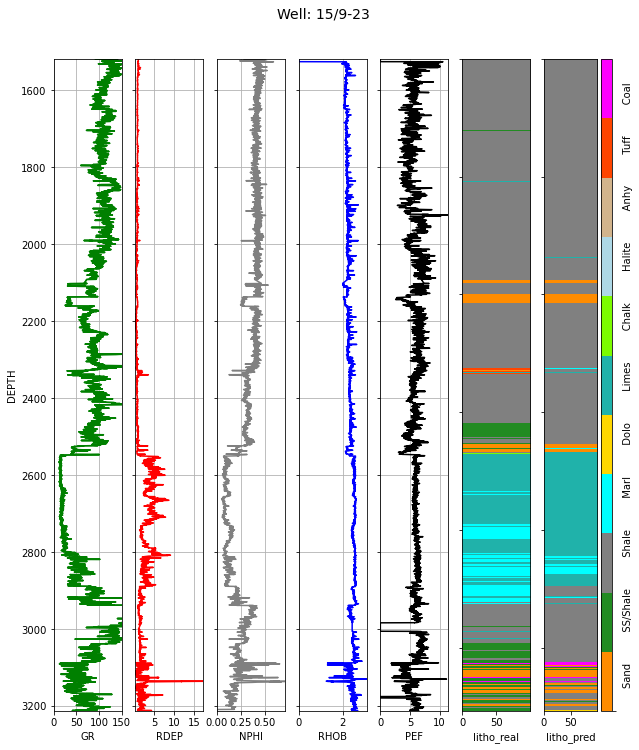

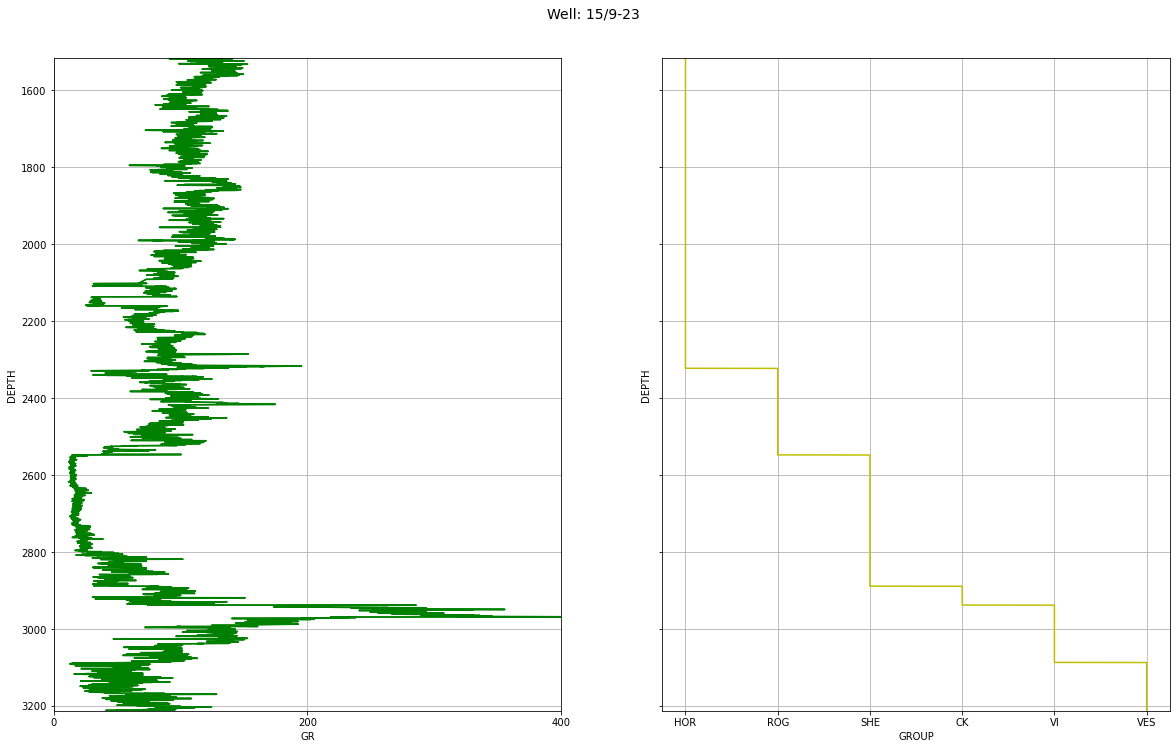

In [161]:
print('No of valid wells: %s' % len(test_wells))
well_no=5
log = pd.concat([X_hid, 
                  y_hid], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })


logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '15/9-23']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '15/9-23', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '15/9-23', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

<ipython-input-36-32c087db5db3>:19: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


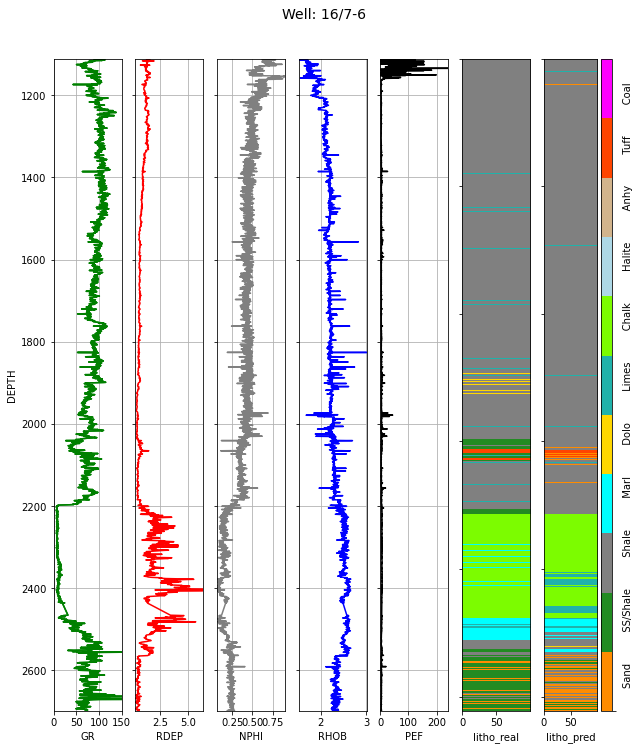

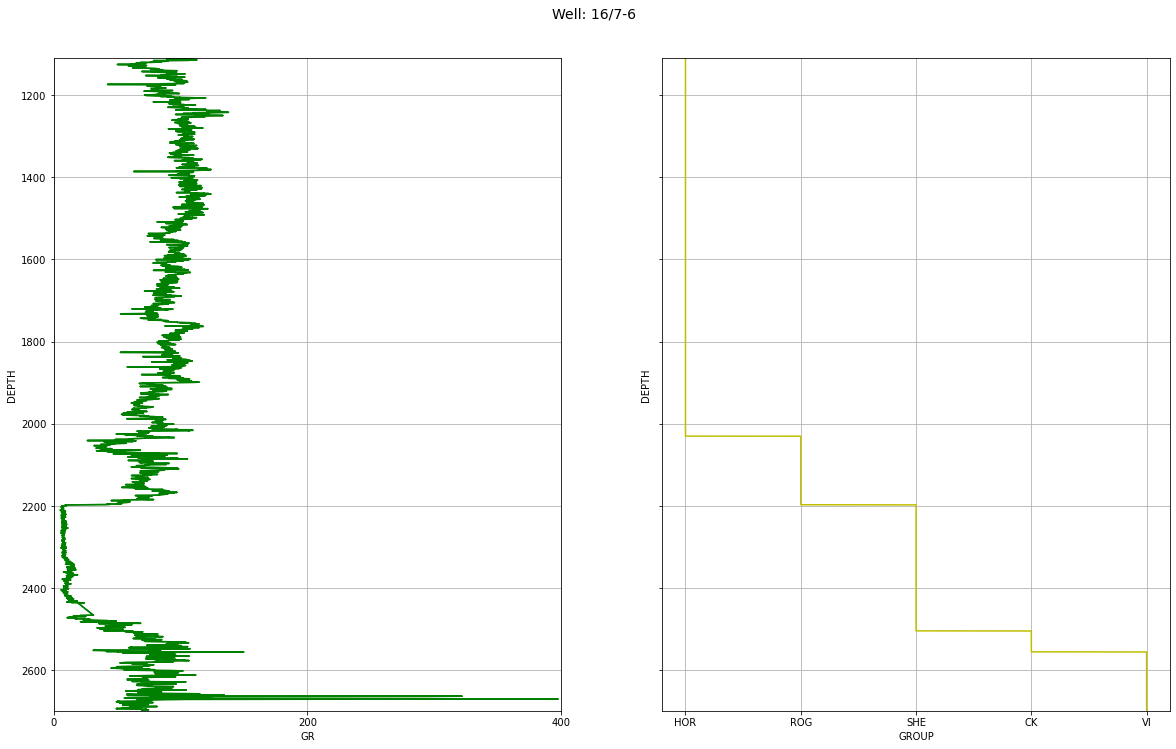

In [162]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '16/7-6']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '16/7-6', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '16/7-6', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

<ipython-input-36-32c087db5db3>:19: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


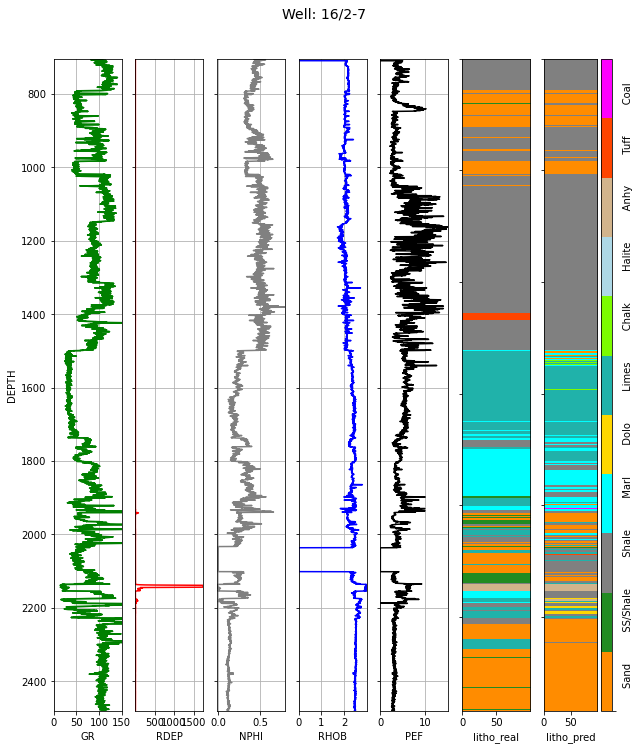

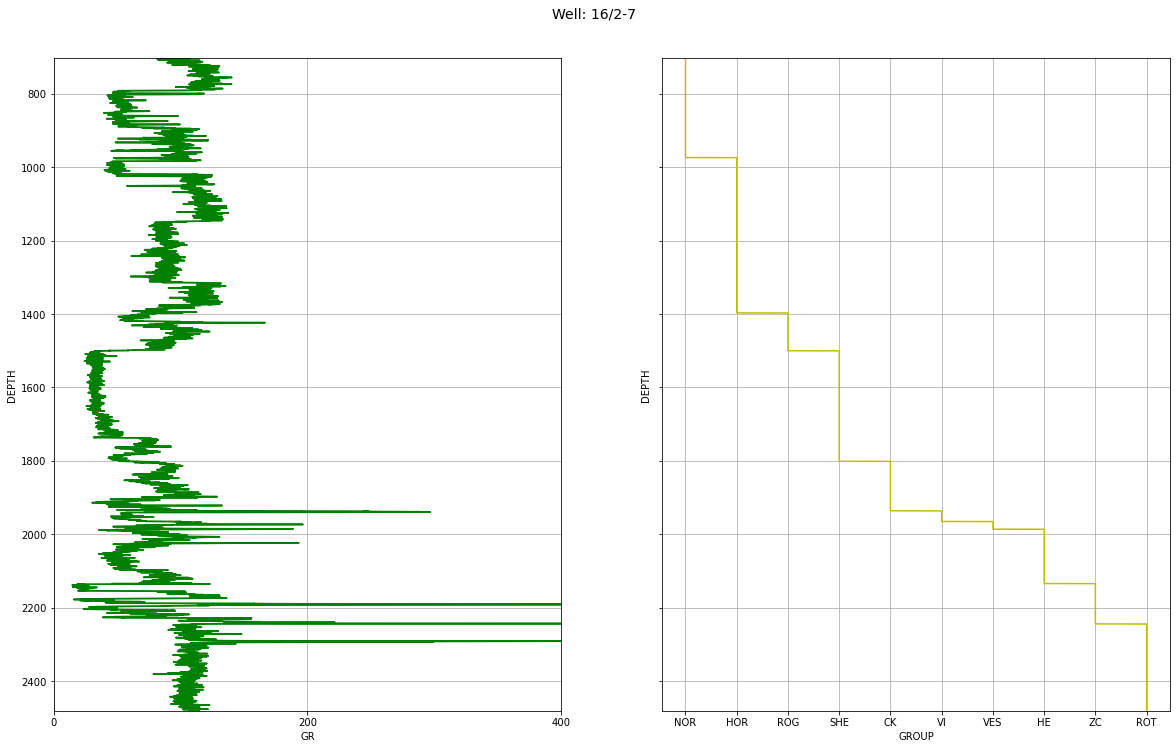

In [163]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '16/2-7']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '16/2-7', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '16/2-7', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

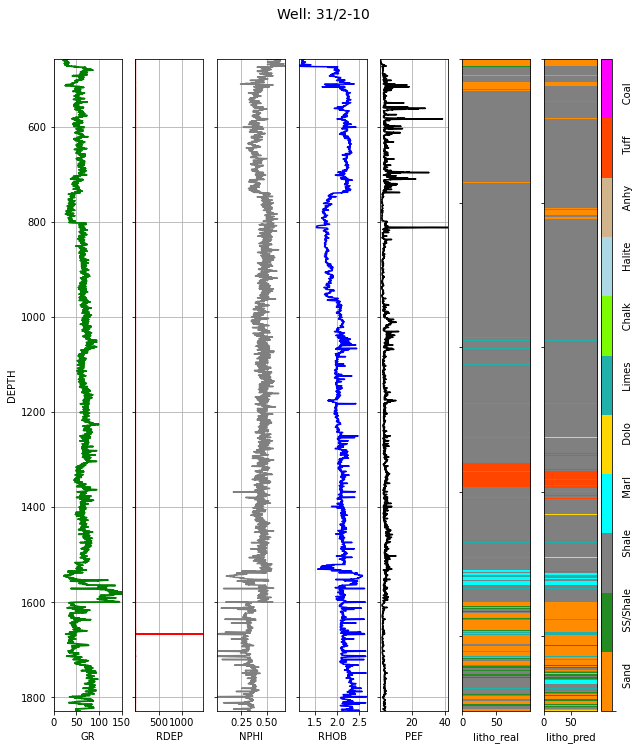

In [164]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '31/2-10']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '31/2-10', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
# group(logs, '31/2-10', facies_names,
#                     facies_colors_blind, 
#                     int(np.unique(y_hid).max()))

<ipython-input-35-c51f82fe491a>:111: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax[4].set_xlim(logs.PEF.min(),logs.PEF.max())
<ipython-input-36-32c087db5db3>:19: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


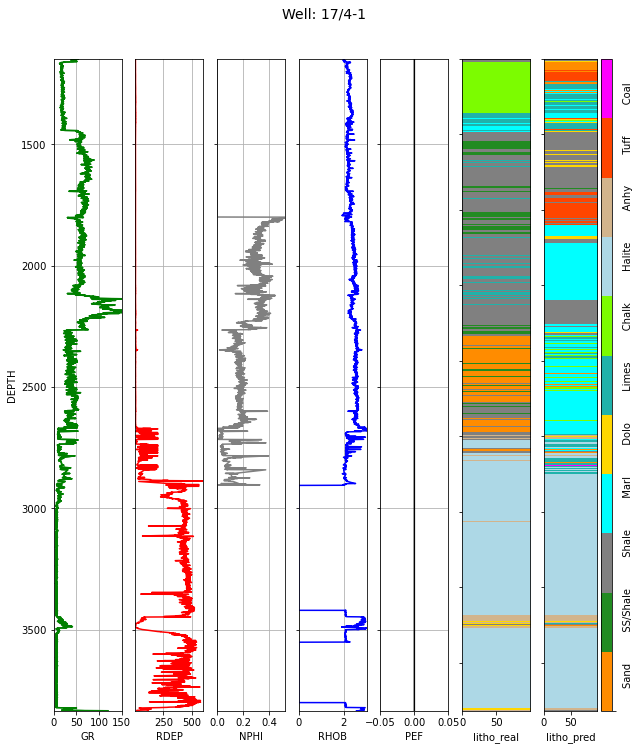

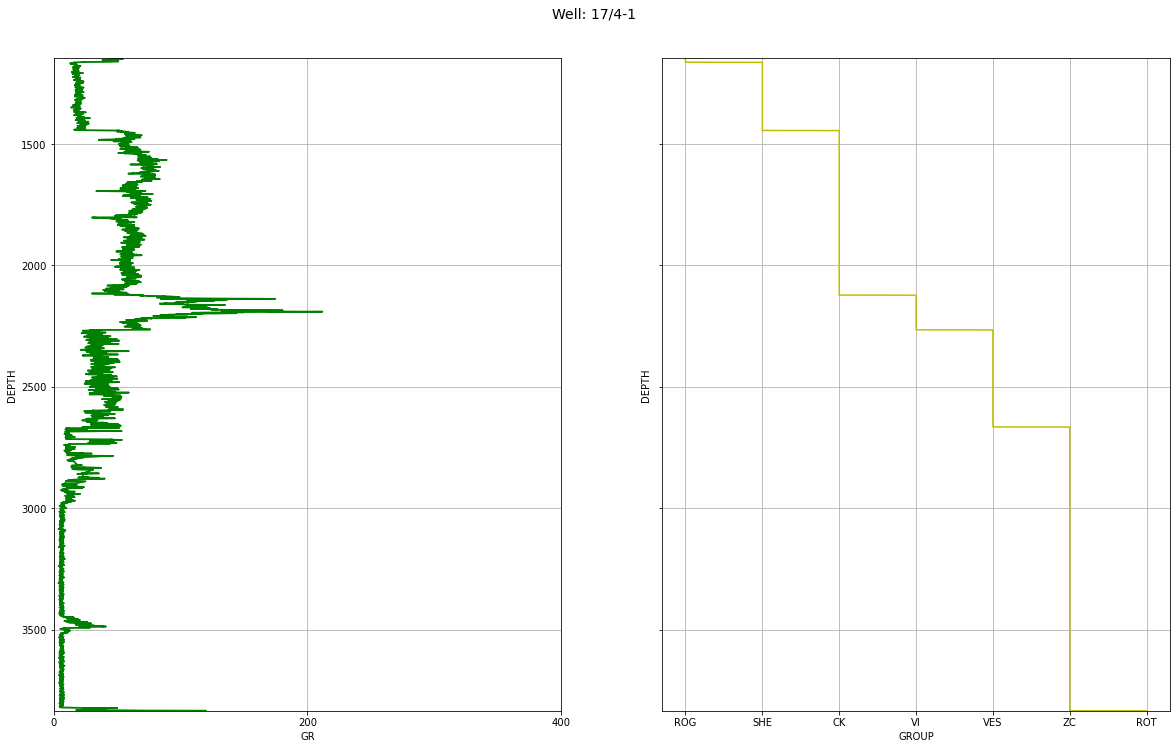

In [165]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '17/4-1']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '17/4-1', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '17/4-1', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

<ipython-input-36-32c087db5db3>:19: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


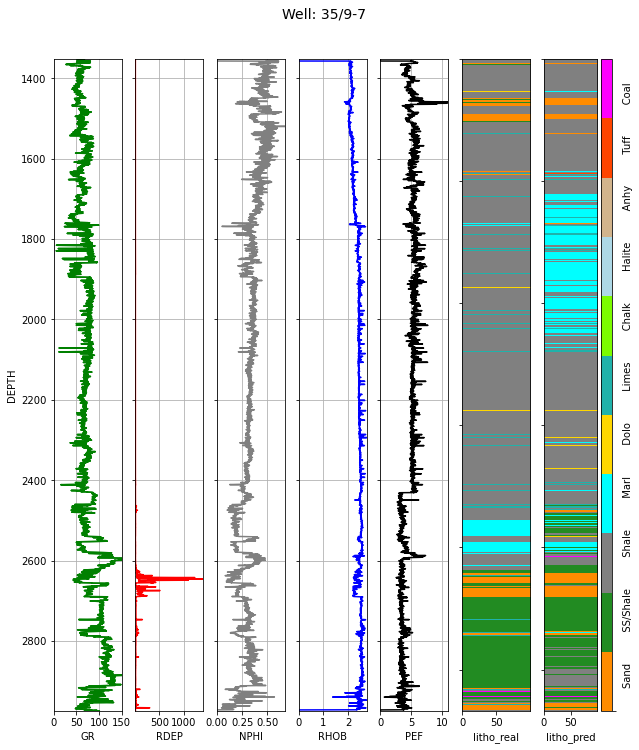

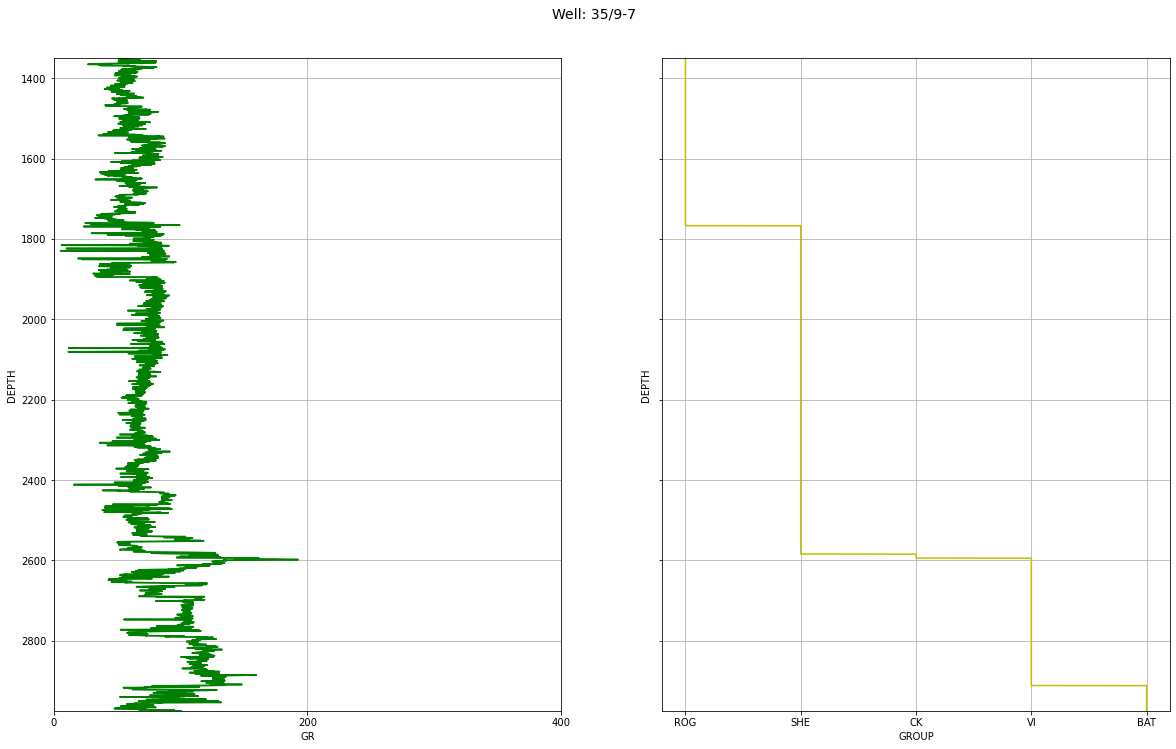

In [197]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '35/9-7']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '35/9-7', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '35/9-7', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

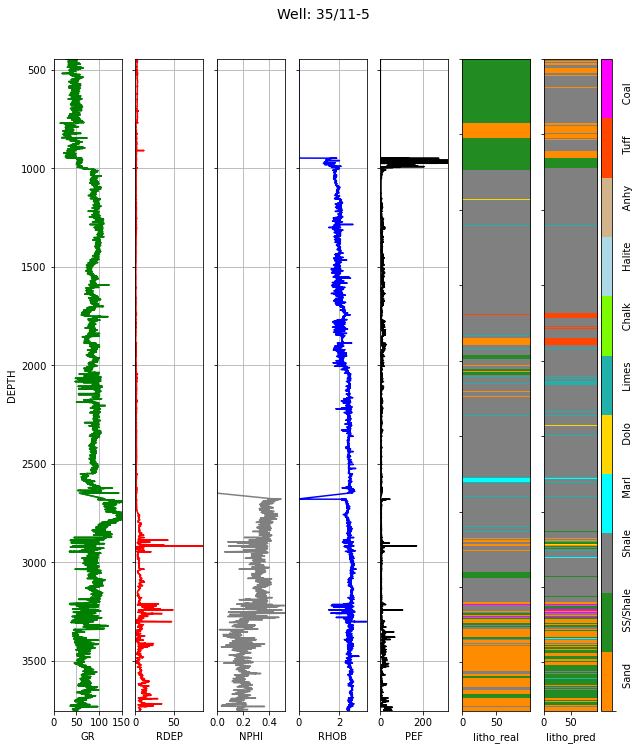

In [167]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '35/11-5']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '35/11-5', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

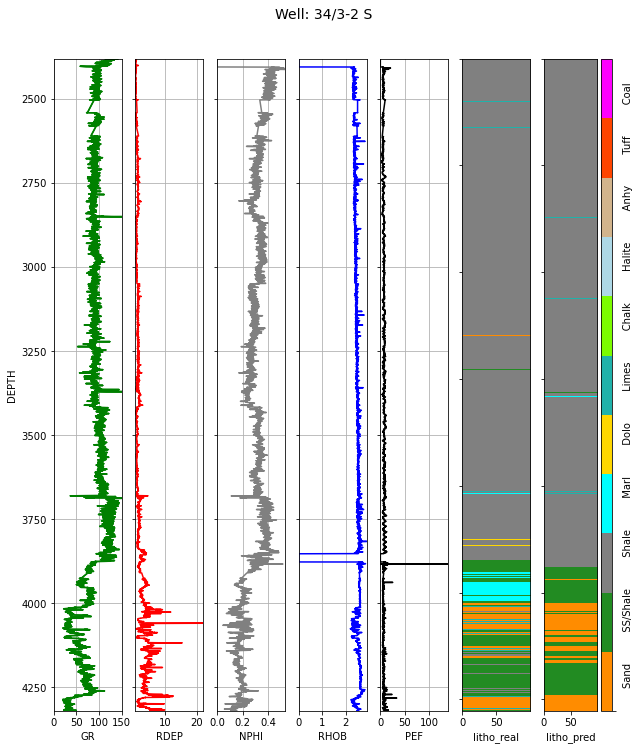

In [200]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '34/3-2 S']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '34/3-2 S', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

In [151]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '35/11-5']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '35/11-5', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '35/11-5', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

array(['15/9-23', '16/2-7', '16/7-6', '17/4-1', '25/10-9', '31/2-10',
       '31/2-21 S', '34/3-2 S', '35/11-5', '35/9-7'], dtype=object)

In [75]:
def make_facies_log_plot(logs, curves, well_name, facies_colors):
        
    #make sure logs are sorted by depth
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')

    colours=['b','r','g','m','c','lime','gold','sienna']
    
    ztop=logs.Depth.min(); zbot=1000
    
    
    
    
    cluster=np.repeat(logs['litho_real'].values.reshape(-1, 1),50,axis=1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs.Depth,colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)
    
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Lithology')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'% well_name, fontsize=14,y=0.94)    
    
def group(logs, well_name):
    
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
   
    
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
  
    ax[1].plot(logs.GROUP1, logs.Depth, '-', color='y')
   
    
    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_ylabel("DEPTH")
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(0,400)
    ax[1].set_ylabel("DEPTH")

    ax[1].set_xlabel("GROUP")
    #ax[5].set_xlim(0,15)
    
   
    
    ax[1].set_yticklabels([]);
    
   
    f.suptitle('Well: %s' % well_name, fontsize=14,y=0.94) 

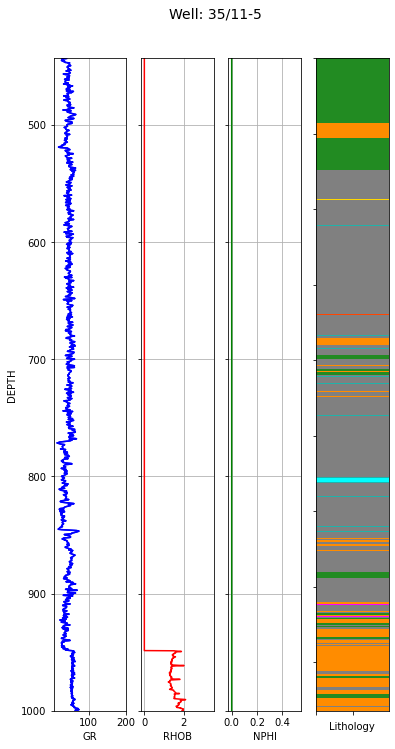

In [76]:
well = hidden_test['WELL']
test_well = hidden_test['WELL'].unique()
well_no=8
logs = pd.concat([X_test, 
                  y_test], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })
make_facies_log_plot(logs[well==test_well[well_no]], ['GR', 'RHOB', 'NPHI'],
                     test_well[well_no],
                     facies_colors)
logs=logs[logs['WELL']== '35/3-7 S']

<ipython-input-134-f37dd30cc86a>:19: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


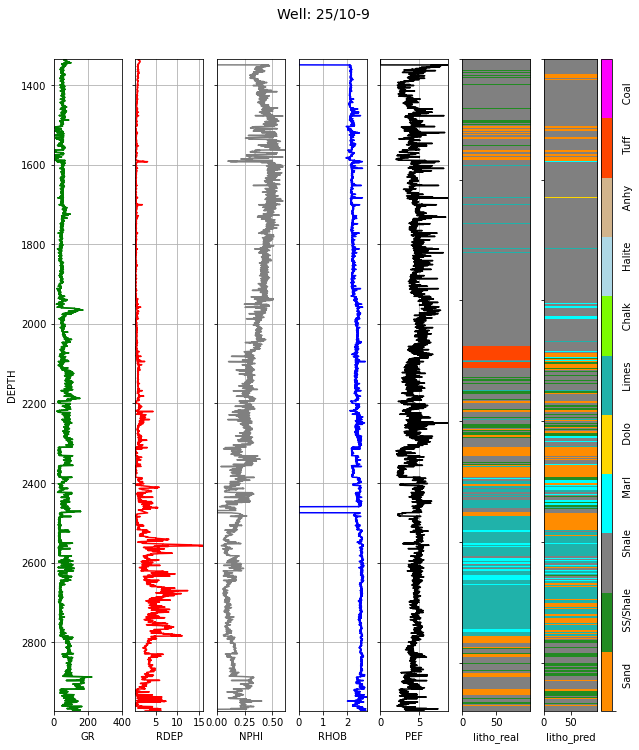

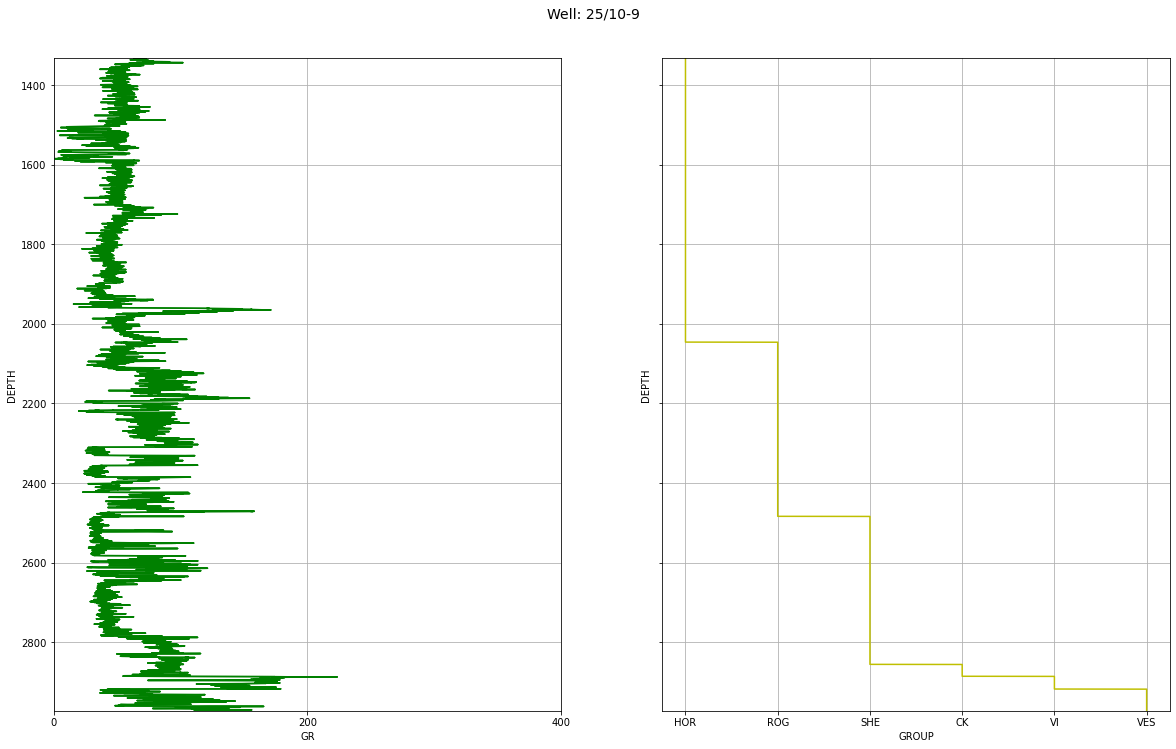

In [152]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '25/10-9']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '25/10-9', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '25/10-9', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

<ipython-input-134-f37dd30cc86a>:19: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


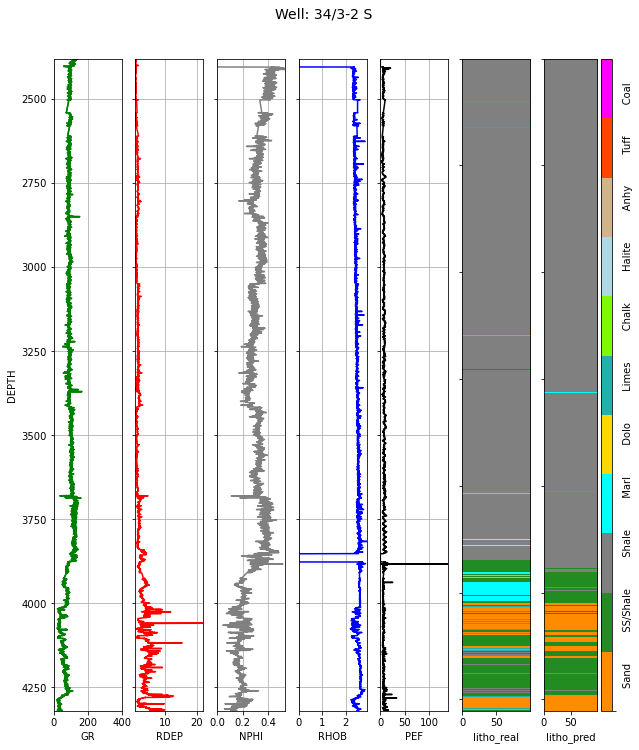

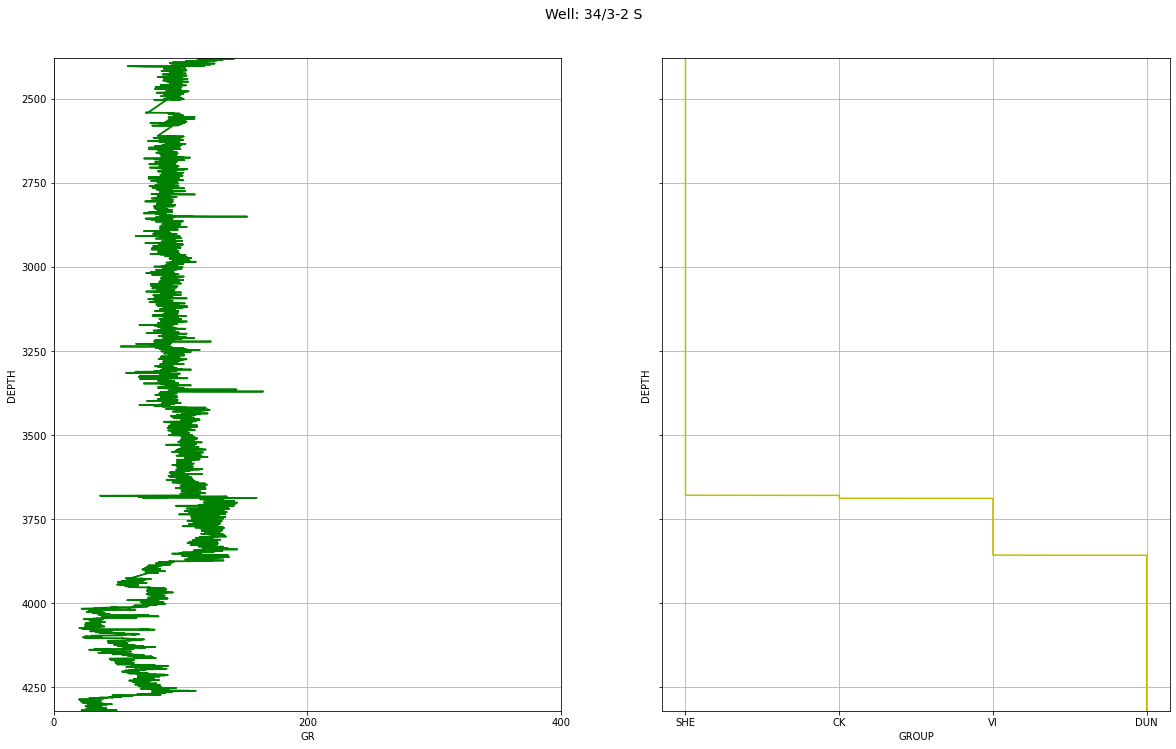

In [153]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '34/3-2 S']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '34/3-2 S', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '34/3-2 S', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

<ipython-input-134-f37dd30cc86a>:19: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


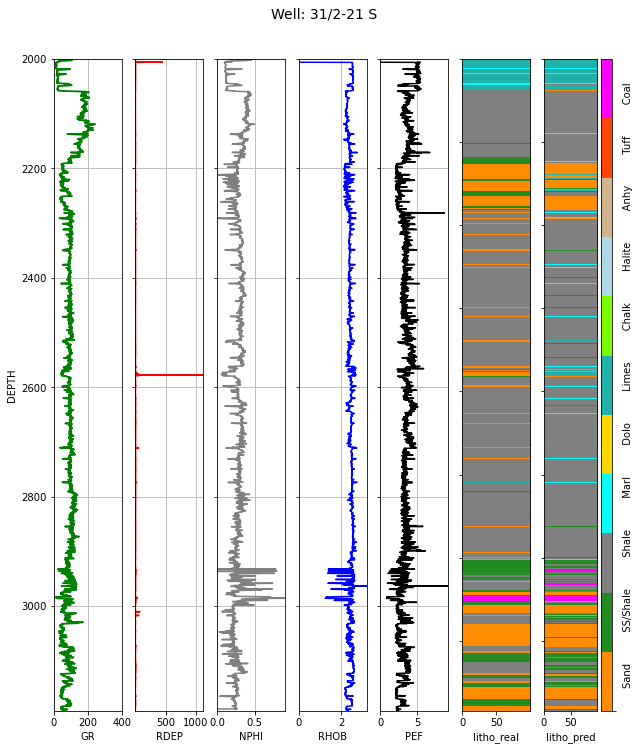

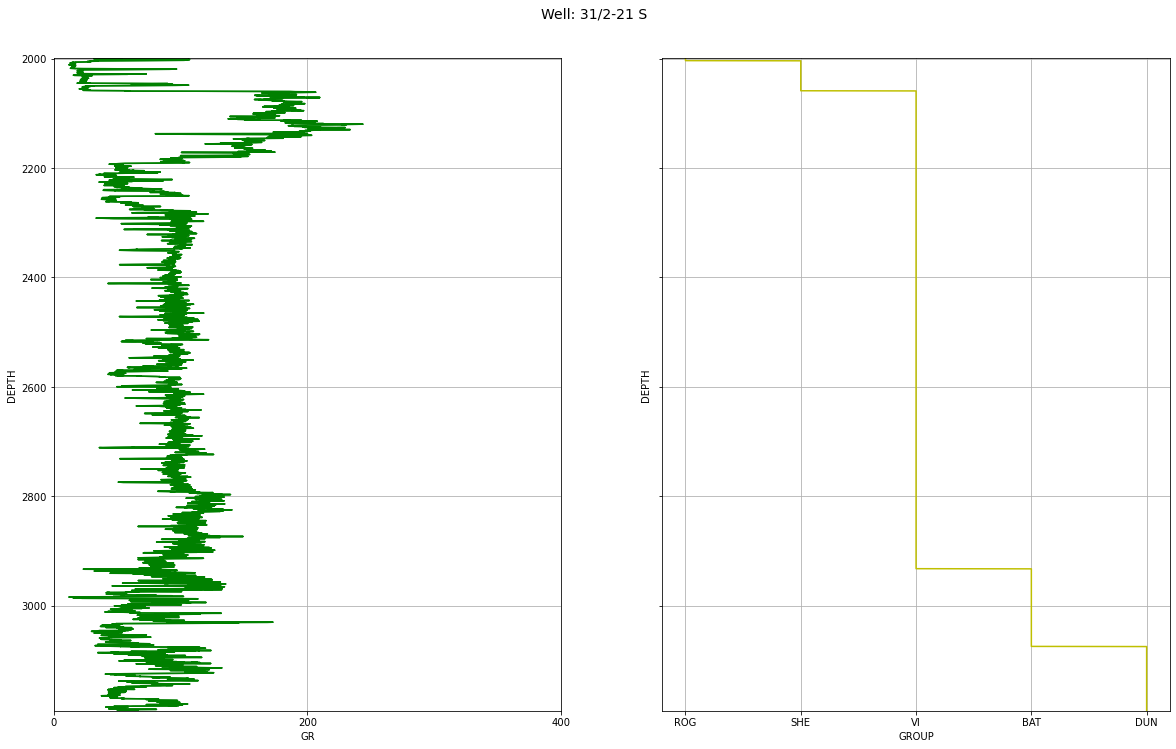

In [154]:
logs = pd.concat([log, pd.Series(hidden_pred, index=y_hid.index)], axis=1).rename(columns = {0:'litho_pred'})
test_wells = logs['WELL'].unique()
logs=logs[logs['WELL']== '31/2-21 S']
#facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
facies_colors_blind = [facies_colors[int(np.unique(y_hid)[i])] for i in range(np.unique(y_hid).shape[0])]
compare_facies_plot(logs, '31/2-21 S', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))
group(logs, '31/2-21 S', facies_names,
                    facies_colors_blind, 
                    int(np.unique(y_hid).max()))

## Break

In [95]:
train_well = data['WELL'].unique()

X_train, y_train =prep(data)

lithofacies = {0: 'Sandstone', 1: 'Sandstone/Shale',
               2: 'Shale', 3: 'Marl', 4: 'Dolomite', 5: 'Limestone', 6: 'Chalk', 7: 'Halite',
               8: 'Anhydrite', 9: 'Tuff',10: 'Coal', 11: 'Basement'}

facies_names = lithofacies.values()

facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']

facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

In [156]:
print('No of train wells: %s' % len(train_well))

No of train wells: 98


In [41]:
X_train

,DEPTH_MD,WELL,GROUP,CALI,GR,RHOB,GR,NPHI,PEF,DRHO,RMED,RDEP
0,494.5280,15/9-13,NORDLAND GP.,19.480835,80.200851,1.884186,80.200851,0.0,20.915468,-0.574928,1.611410,1.798681
1,494.6800,15/9-13,NORDLAND GP.,19.468800,79.262886,1.889794,79.262886,0.0,19.383013,-0.570188,1.618070,1.795641
2,494.8320,15/9-13,NORDLAND GP.,19.468800,74.821999,1.896523,74.821999,0.0,22.591518,-0.574245,1.626459,1.800733
3,494.9840,15/9-13,NORDLAND GP.,19.459282,72.878922,1.891913,72.878922,0.0,32.191910,-0.586315,1.621594,1.801517
4,495.1360,15/9-13,NORDLAND GP.,19.453100,71.729141,1.880034,71.729141,0.0,38.495632,-0.597914,1.602679,1.795299
...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,3169.3124,7/1-2 S,VESTLAND GP.,8.423170,77.654900,2.527984,77.654900,0.0,4.586425,-0.001763,0.000000,0.000000
1170507,3169.4644,7/1-2 S,VESTLAND GP.,8.379244,75.363937,2.537613,75.363937,0.0,7.019858,-0.007600,0.000000,0.000000
1170508,3169.6164,7/1-2 S,VESTLAND GP.,8.350248,66.452843,2.491860,66.452843,0.0,9.049782,-0.018297,0.000000,0.000000
1170509,3169.7684,7/1-2 S,VESTLAND GP.,8.313779,55.784817,2.447539,55.784817,0.0,8.903917,-0.011438,0.000000,0.000000


In [96]:
X_train['GROUP1']= X_train['GROUP'].map(group_dict)
X_train['GROUP2']= X_train['GROUP'].map(group_dict_num)
X_train

,DEPTH_MD,WELL,GROUP,CALI,GR,RHOB,GR,NPHI,PEF,DRHO,RMED,RDEP,GROUP1,GROUP2
0,494.5280,15/9-13,NORDLAND GP.,19.480835,80.200851,1.884186,80.200851,0.0,20.915468,-0.574928,1.611410,1.798681,NOR,1
1,494.6800,15/9-13,NORDLAND GP.,19.468800,79.262886,1.889794,79.262886,0.0,19.383013,-0.570188,1.618070,1.795641,NOR,1
2,494.8320,15/9-13,NORDLAND GP.,19.468800,74.821999,1.896523,74.821999,0.0,22.591518,-0.574245,1.626459,1.800733,NOR,1
3,494.9840,15/9-13,NORDLAND GP.,19.459282,72.878922,1.891913,72.878922,0.0,32.191910,-0.586315,1.621594,1.801517,NOR,1
4,495.1360,15/9-13,NORDLAND GP.,19.453100,71.729141,1.880034,71.729141,0.0,38.495632,-0.597914,1.602679,1.795299,NOR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,3169.3124,7/1-2 S,VESTLAND GP.,8.423170,77.654900,2.527984,77.654900,0.0,4.586425,-0.001763,0.000000,0.000000,VES,8
1170507,3169.4644,7/1-2 S,VESTLAND GP.,8.379244,75.363937,2.537613,75.363937,0.0,7.019858,-0.007600,0.000000,0.000000,VES,8
1170508,3169.6164,7/1-2 S,VESTLAND GP.,8.350248,66.452843,2.491860,66.452843,0.0,9.049782,-0.018297,0.000000,0.000000,VES,8
1170509,3169.7684,7/1-2 S,VESTLAND GP.,8.313779,55.784817,2.447539,55.784817,0.0,8.903917,-0.011438,0.000000,0.000000,VES,8


<ipython-input-160-2d6e030ad51f>:69: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


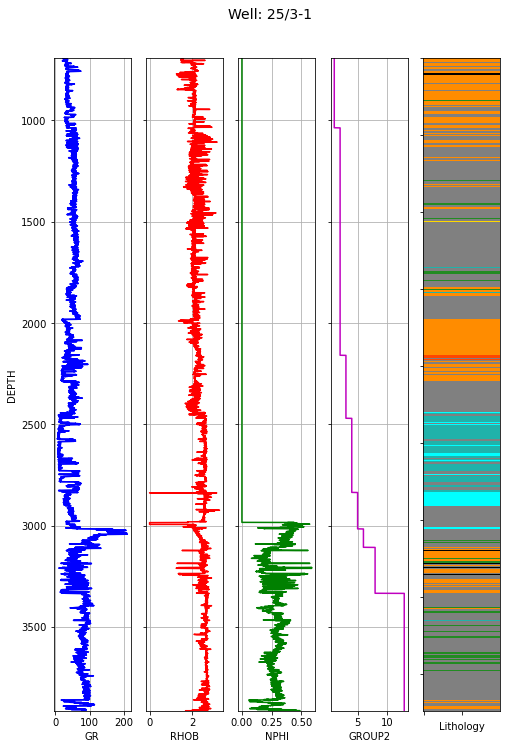

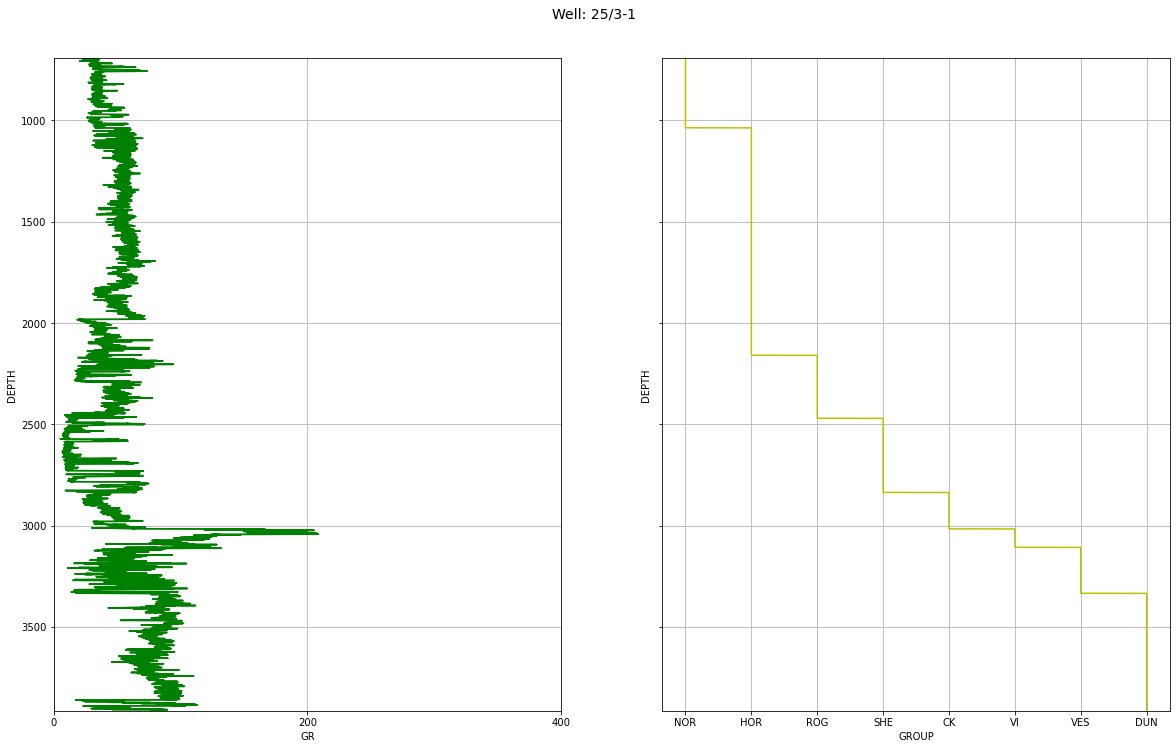

In [162]:
well_no=25
logs = pd.concat([X_train, 
                  y_train], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                              })
#logs=logs[logs['WELL']== '25/6-2']
make_facies_log_plot(logs[well==train_well[well_no]], ['GR', 'RHOB', 'NPHI', 'GROUP2'],
                     train_well[well_no],
                     facies_colors)
logs=logs[logs['WELL']== '25/3-1']
group(logs, '25/3-1')


<ipython-input-153-e1aa92488f90>:69: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


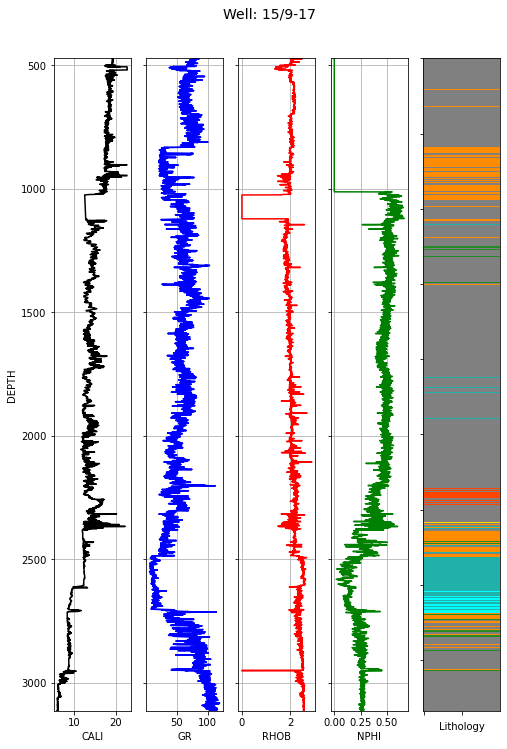

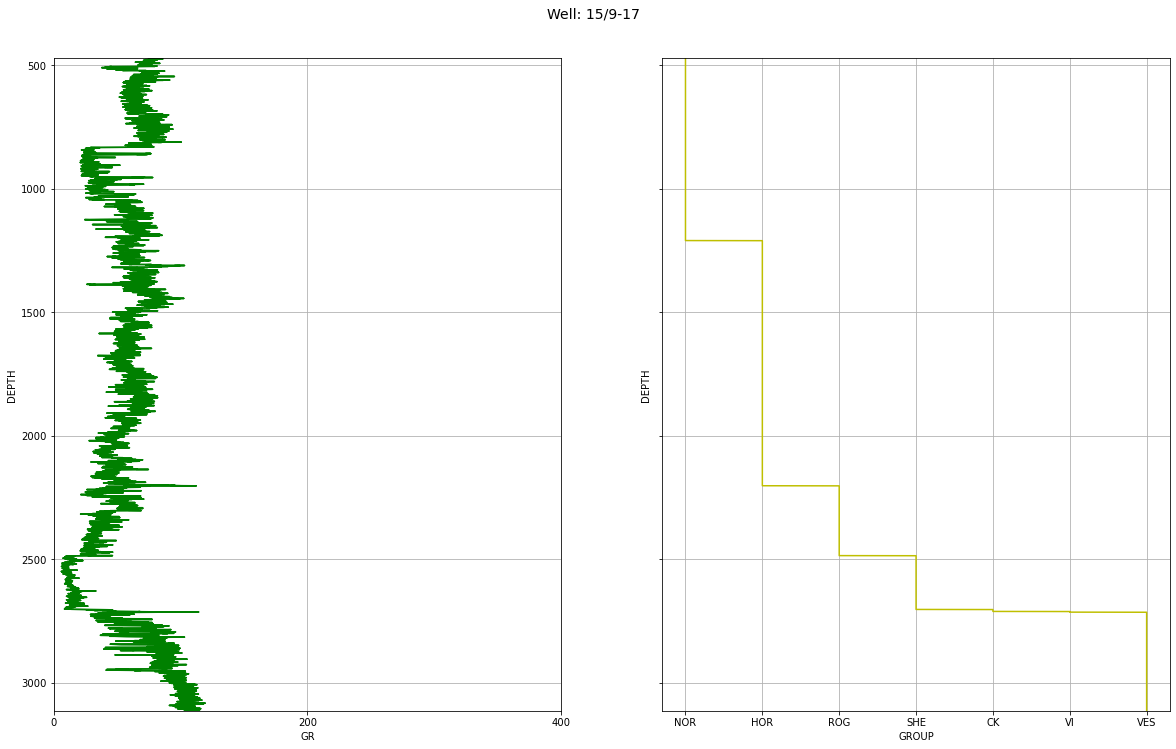

In [157]:
well_no=2
logs = pd.concat([X_train, 
                  y_train], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })
make_facies_log_plot(logs[well==train_well[well_no]], ['CALI', 'GR', 'RHOB', 'NPHI'],
                     train_well[well_no],
                     facies_colors)
logs=logs[logs['WELL']== '15/9-17']
group(logs, '15/9-17')

In [170]:
well_no=80
logs = pd.concat([X_train, 
                  y_train], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })
make_facies_log_plot(logs[well==train_well[well_no]], ['GR', 'RHOB', 'NPHI', 'GROUP2'],
                     train_well[well_no],
                     facies_colors)
logs=logs[logs['WELL']== '35/11-11']
group(logs, '35/11-11')

AttributeError: 'DataFrame' object has no attribute 'Depth'

In [74]:
train_well

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

<ipython-input-160-2d6e030ad51f>:69: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax[i].locator_params(axis='x', nbins=3)


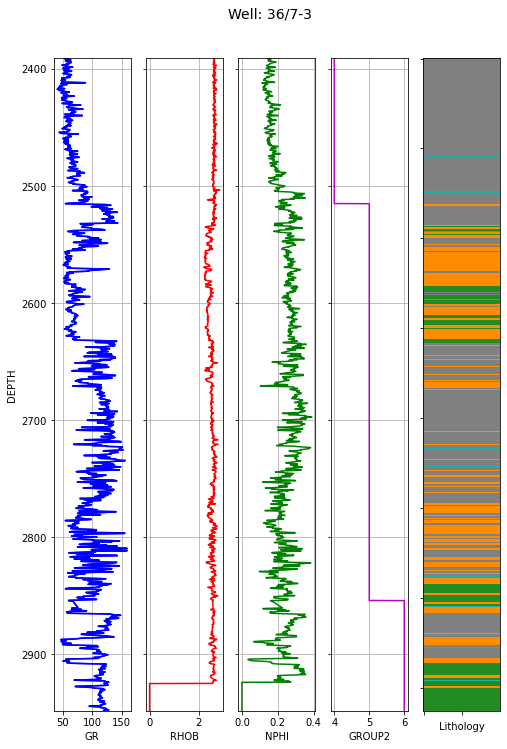

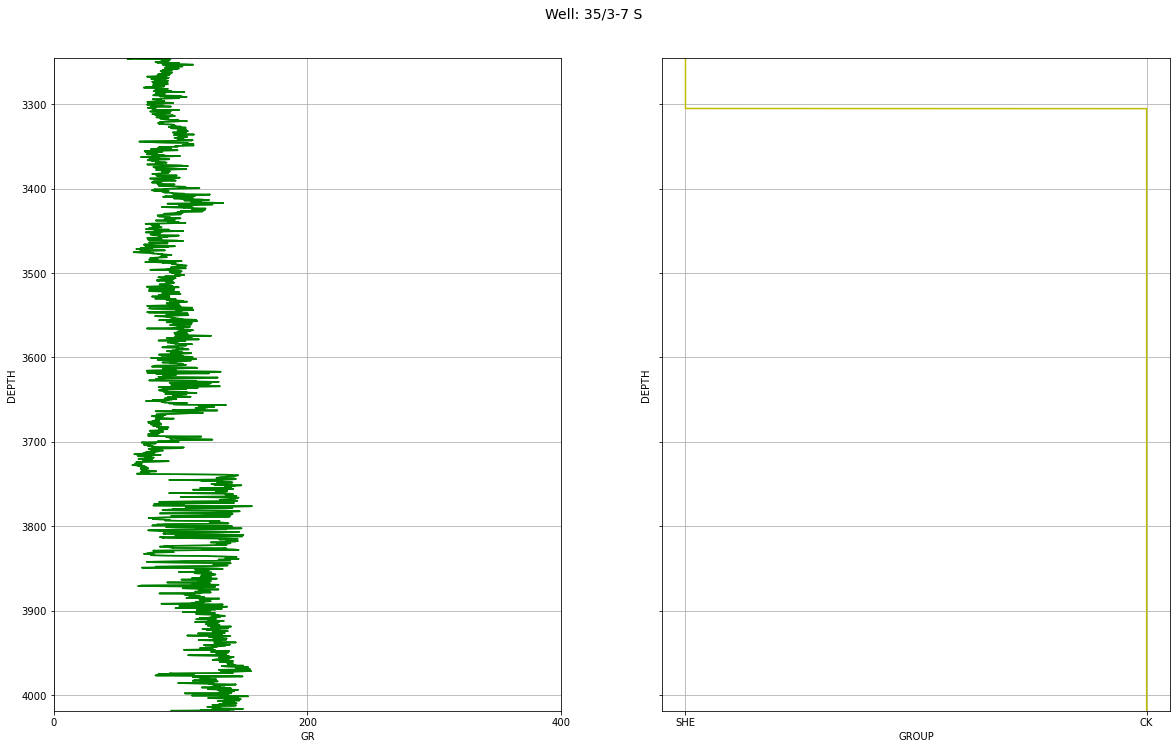

In [167]:
well_no=95
logs = pd.concat([X_train, 
                  y_train], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })
make_facies_log_plot(logs[well==train_well[well_no]], ['GR', 'RHOB', 'NPHI', 'GROUP2'],
                     train_well[well_no],
                     facies_colors)
logs=logs[logs['WELL']== '35/3-7 S']
group(logs, '35/3-7 S')

In [65]:
X_test, y_test =prep(hidden_test)
X_test['GROUP']= X_test['GROUP'].map(group_dict)
test_well = hidden_test['WELL'].unique()

NameError: name 'group_dict' is not defined

In [64]:
well_no=4
logs = pd.concat([X_test, 
                  y_test], axis=1).rename(columns = {'FORCE_2020_LITHOFACIES_LITHOLOGY':'litho_real', 'DEPTH_MD':'Depth'
                                               })
make_facies_log_plot(logs[well==test_well[well_no]], ['CALI', 'GR', 'RHOB', 'NPHI'],
                     test_well[well_no],
                     facies_colors)
logs=logs[logs['WELL']== '35/11-11']
group(logs, '35/11-11')

NameError: name 'X_test' is not defined